In [102]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests
import shutil

from bs4 import BeautifulSoup
from datetime import datetime
from pathlib import Path
from pytz import timezone, utc

now = datetime.utcnow()
kst = timezone('Asia/Seoul')
now_date = utc.localize(now).astimezone(kst).strftime('%Y%m%d')

# 사이트 크롤링
req = requests.get("http://ncov.mohw.go.kr/")
html = req.text
soup = BeautifulSoup(html, 'html.parser')
link = soup.find("strong", class_='tit').select('a')
latest = link[0].get('href')

# 리눅스/윈도우 호환성
base_dir = Path().resolve()
file_name = f'covidstat_{now_date}.xlsx'

# 엑셀 다운로드
URL: str = f"http://ncov.mohw.go.kr{latest}"
with requests.get(URL, stream=True) as response:
    with open(os.path.join(base_dir, file_name), 'wb+') as f :
        shutil.copyfileobj(response.raw, f)

# xlsx 불러오기
df = pd.read_excel(str(os.path.join(base_dir, file_name)))

# 헤더를 제대로 못읽으므로 변환
df = df.iloc[5:, :2].rename(columns=df.iloc[3])
df = df.rename(columns={'일자' : 'date', '계(명)' : 'confirmed'})
df

,date,confirmed
5,2020-01-20 00:00:00,1
6,2020-01-21 00:00:00,0
7,2020-01-22 00:00:00,0
8,2020-01-23 00:00:00,0
9,2020-01-24 00:00:00,1
...,...,...
584,2021-08-21 00:00:00,1879
585,2021-08-22 00:00:00,1626
586,2021-08-23 00:00:00,1417
587,2021-08-24 00:00:00,1509


In [103]:
# 누적합 추가
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['total_confirmed'] = df['confirmed'].cumsum()
df

,date,confirmed,total_confirmed
5,2020-01-20,1,1
6,2020-01-21,0,1
7,2020-01-22,0,1
8,2020-01-23,0,1
9,2020-01-24,1,2
...,...,...,...
584,2021-08-21,1879,234732
585,2021-08-22,1626,236358
586,2021-08-23,1417,237775
587,2021-08-24,1509,239284


In [104]:
import plotly.graph_objs as go
import plotly.offline as py

fig = go.Figure()

# 누적 확진자 수
fig.add_trace(
    go.Scatter(
        x=df.date,
        y=df.total_confirmed,
        name='total confirmed in Korea'
    )
)

In [105]:
# 일일 확진자 수
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df.date,
        y=df.confirmed,
        name='daily number of confirmed cases in Korea'
    )
)

In [106]:
# fbprophet를 이용한 추후 누적 확진자수 예측
import logging

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

logging.getLogger('fbprophet').setLevel(logging.WARNING)

df_prophet = df.rename(columns={
    'date': 'ds',
    'total_confirmed': 'y'
})
df_prophet = df_prophet.iloc[:, [0, 2]]
df_prophet

,ds,y
5,2020-01-20,1
6,2020-01-21,1
7,2020-01-22,1
8,2020-01-23,1
9,2020-01-24,2
...,...,...
584,2021-08-21,234732
585,2021-08-22,236358
586,2021-08-23,237775
587,2021-08-24,239284


In [107]:
m = Prophet(
    changepoint_prior_scale=0.3,
    changepoint_range=0.98,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='additive'
)

m.fit(df_prophet)

In [108]:
future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
679,2021-11-29,415218.236345,382944.134417,447647.341501
680,2021-11-30,416964.740992,383945.566973,450256.310241
681,2021-12-01,418826.801381,385871.235053,452262.767048
682,2021-12-02,420673.021357,387484.788892,454716.736130
683,2021-12-03,422505.676759,388834.064178,457161.325534


In [109]:
fig = plot_plotly(m, forecast)
py.iplot(fig)

In [110]:
# fbprophet를 이용한 추후 일별 확진자수 예측
from fbprophet.plot import add_changepoints_to_plot

df_prophet = df.rename(columns={
    'date': 'ds',
    'confirmed': 'y'
})
df_prophet = df_prophet.iloc[:, [0, 1]]

m = Prophet(
    changepoint_prior_scale=0.3,
    changepoint_range=0.98,
    yearly_seasonality='auto',
    weekly_seasonality='auto',
    daily_seasonality='auto',
    seasonality_mode='additive'
)

m.fit(df_prophet)

future = m.make_future_dataframe(periods=100)
forecast = m.predict(future)

fig = plot_plotly(m, forecast)
py.iplot(fig)

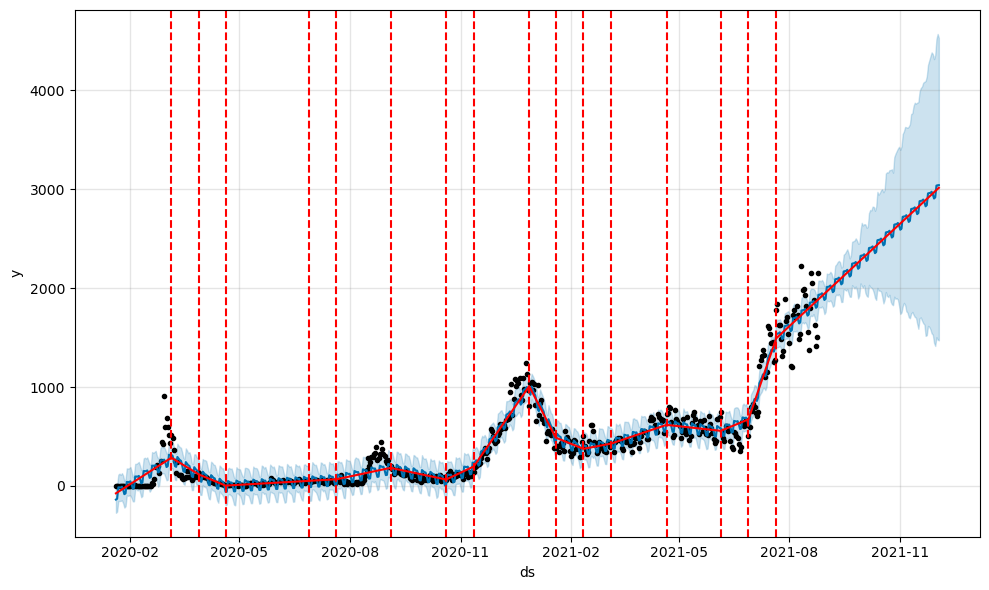

In [111]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.show()
plt.close()

In [202]:
# SEIR 모델 사용

import scipy.integrate as sp
import numpy as np
import re

req = requests.get("http://ncov.mohw.go.kr/")
html = req.text
soup = BeautifulSoup(html, 'html.parser')
confirmed = soup.select('ul[class="liveNum"] > li')

# 확진자, 격리해제, 격리중, 사망
confirmed_list: list = []
for i in range(len(confirmed)):
    confirmed_list.append(int(''.join(re.findall(r"\d+", confirmed[i].select_one('span[class="num"]').text))))

inspections = soup.select('div[class="cc_figure"] > p')

# 검사중, 양성, 음성
inspection_list: list = []

for i in range(len(inspections)):
    inspection_list.append(int(''.join(re.findall(r"\d+", inspections[i].select_one('span[class=num_rnum]').text))))

# 총 인구수
population: int = 0
req = requests.get("https://jumin.mois.go.kr/ageStatMonth.do")
html = req.text
soup = BeautifulSoup(html, 'html.parser')
total = soup.select('table[id="contextTable"] > tbody > tr > td')
population = int(''.join(re.findall(r"\d+", total[3].text)))

# S0 = 총 인구
# E0 = 검사중
# I0 = 확진자
# R0 = 완치자 + 사망자

# S0
S0: float = population - inspection_list[0] * 0.02 - sum(confirmed_list[1:])

# E0, 확진 비율은 약 2%
E0: float = inspection_list[0] * 0.02

# I0
I0: float = confirmed_list[2]

# R0
R0: float = confirmed_list[1] + confirmed_list[3]

# SEIR 계산

간단하게는 '재생산지수 = infection rate / recovery rate' 로 표현이 가능하다.
여기서의 기본 재생산지수의 표기는 recovery rate를 R0로 표기하고 있기에 Ro로 표기하겠다.

    Ro: float = 1 + today_confirmed_list[2] / (today_confirmed_list[1] + today_confirmed_list[3])
    Rn: float = Ro * (1 - v)

v는 백신 접종률, Rn은 Ro에서 백신 접종 비율을 고려한 재생산지수
이는 단순 추측일 뿐이며, beta값을 계산하기 위한 스탭이므로 beta값은 다른 논문을 찾아서 fit하는 것으로 결정.
* * *
gamma는 하루에 평균적으로 회복하는 비율
완치 기준은 [여기](https://m.health.chosun.com/svc/news_view.html?contid=2020062902672)를 참고, 하루에 회복하는 비율은 1/20

beta는 하루에 평균적으로 걸리는 비율이므로 beta = 재생산지수 * gamma
beta = Ro * gamma

[여기](http://kostat.go.kr/sri/srikor/srikor_pbl/4/index.board?bmode=download&aSeq=383404&sort=1) 를 참고하여 
beta값은 고정시켜봤으나 현 상황에서는 다르게 적용하는 것이 맞음. ( 최근 8월 기사에 Ro = 1에 근접하므로 )
N = 1로 정규화했을 때의 Ro = beta / gamma이므로 Ro가 1에 근사할 때 beta는 gamma와 거의 동일해짐.

2021-08-25 기준, 확진자가 점차 증가하는 추세이므로 
[여기](https://www.dongascience.com/news.php?idx=48381) 를 참고, 월 재생산지수는 각 주의 재생산지수의 평균으로 가정하여 
바로 직전 달의 재생산지수인 1.1675로 계산. (1.32 + 1.25 + 1.06 + 1.04) / 4 = 1.1675

sigma는 평균 지연 시간의 역수이며, 보통 확진자 판정 이후 밀접접촉자 검사 - 확진까지의 시간을 4일이라 두면 이의 역수인 1/4가 된다.
epsilon은 재감염율, [여기](https://www.pharmstoday.com/news/articleView.html?idxno=308332) 을 참고하여 0.7%로 두었다.

즉, 회복한 사람들 중에서 하루에 0.7% / 365만큼의 확진자가 추가로 나올 수 있다.
그리고 사망자의 경우 재감염을 고려하지 않으므로 그 비율을 곱해서 재감염율을 계산한다.

In [203]:
# 모집단
N: int = S0 + E0 + I0 + R0

S0 /= N
E0 /= N
I0 /= N
R0 /= N

# 재생산지수, 일일마다 변하므로 이거 역시 파싱으로 계산하려 시도...
req = requests.get("http://ncov.mohw.go.kr/")
html = req.text
soup = BeautifulSoup(html, 'html.parser')
today_confirmed = soup.select('ul[class="liveNum"] > li')

# 오늘의 확진자, 격리해제, 격리중, 사망
# 격리중은 확진자 - 격리해제 - 사망과 동일하므로 일단 집어넣고 계산
today_confirmed_list: list = []
for i in range(len(today_confirmed)):
    today_confirmed_list.append(int(''.join(re.findall(r"\d+", today_confirmed[i].select_one('span[class="before"]').text))))

today_confirmed_list[2] = today_confirmed_list[0] - today_confirmed_list[1] - today_confirmed_list[3]

Ro: float = 1.1675
gamma: float = 1/20
sigma: float = 1/4
beta: float = Ro * gamma
epsilon: float = 0.007 * (confirmed_list[1] / (R0 * N)) / 365

# 사망률과 출생률을 고려해줘야 한다. 작년 데이터를 기준으로 가져옴. https://www.korea.kr/news/policyBriefingView.do?newsId=156438030

# 작년 총 사망자 수 / (총 인구 * 요일)
mu = 305100 / (population * 365)

# 출생률은 총 출생아 수 / (총 인구 * 요일)
v = 272400 / (population * 365)

input_tuple: tuple = (S0, E0, I0, R0)

def seir_calculation(cal_tuple, t):
    '''
        일반적인 SEIR모델
    '''
    Y = np.zeros((4))
    X = cal_tuple
    Y[0] = -beta * X[0] * X[2]
    Y[1] = beta * X[0] * X[2] - sigma * X[1]
    Y[2] = sigma * X[1] - gamma * X[2]
    Y[3] = gamma * X[2]
    
    return Y

def seir_additional_calculation(cal_tuple, t):
    '''
        SEIR에서, 자연사망률을 제외하는 모델, 재감염률 고려
    '''
    Y = np.zeros((4))
    X = cal_tuple
    Y[0] = v - beta * X[0] * X[2] - mu * X[0] + epsilon * X[3]
    Y[1] = beta * X[0] * X[2]  - (sigma + mu) * X[1]
    Y[2] = sigma * X[1] - (gamma + mu) * X[2]
    Y[3] = gamma * X[2] - (mu + epsilon) * X[3]

    return Y

t_start = 0.0
t_end = 100
t_inc = 1.0
t_range = np.arange(t_start, t_end + t_inc, t_inc)

seir = sp.odeint(seir_calculation, input_tuple, t_range)

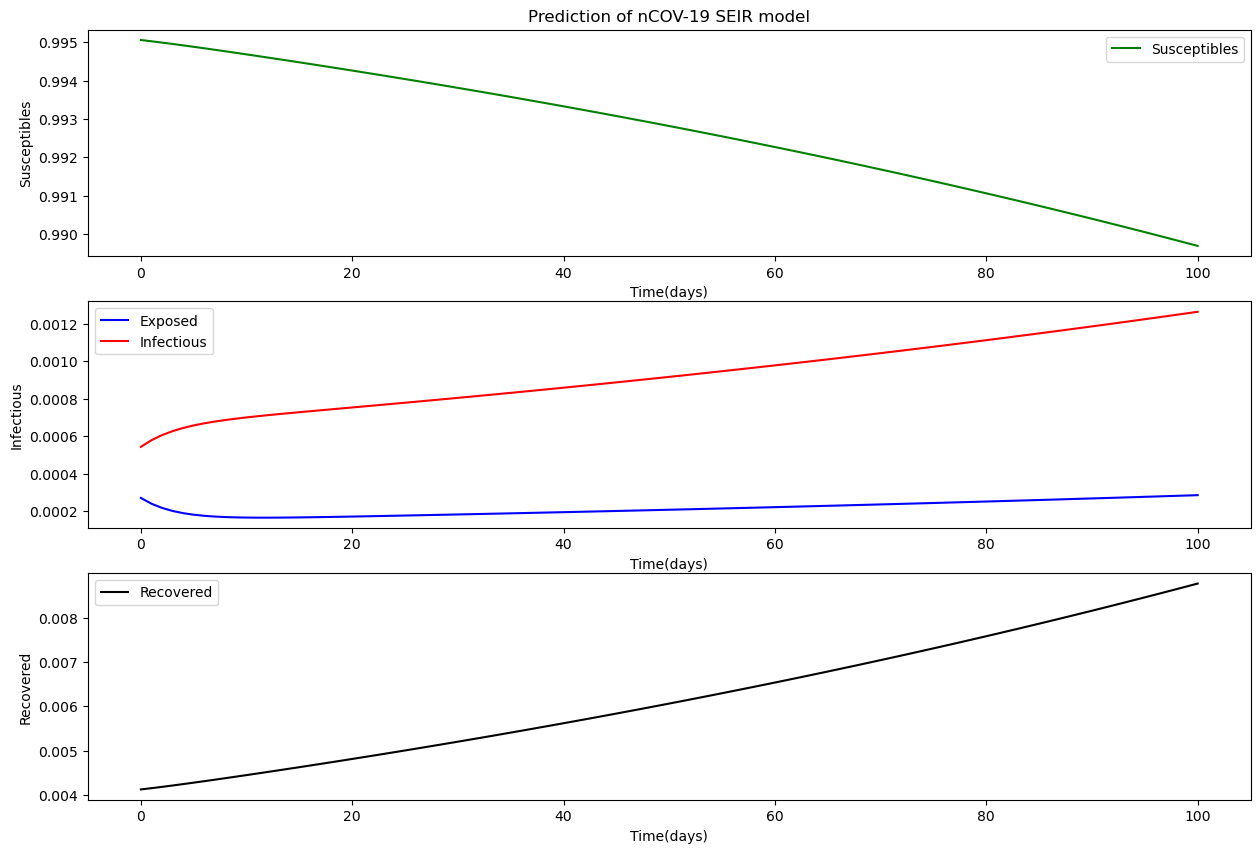

In [204]:
plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(seir[:,0], '-g', label='Susceptibles');plt.legend(loc=0)
plt.title('Prediction of nCOV-19 SEIR model')
plt.xlabel('Time(days)')
plt.ylabel('Susceptibles')

plt.subplot(312)
plt.plot(seir[:,1], '-b', label='Exposed')
plt.plot(seir[:,2], '-r', label='Infectious');plt.legend(loc=0)
plt.xlabel('Time(days)')
plt.ylabel('Infectious')

plt.subplot(313)
plt.plot(seir[:,3], '-k', label='Recovered')
plt.xlabel('Time(days)')
plt.legend(loc=0)
plt.ylabel('Recovered')
plt.show()
plt.close()

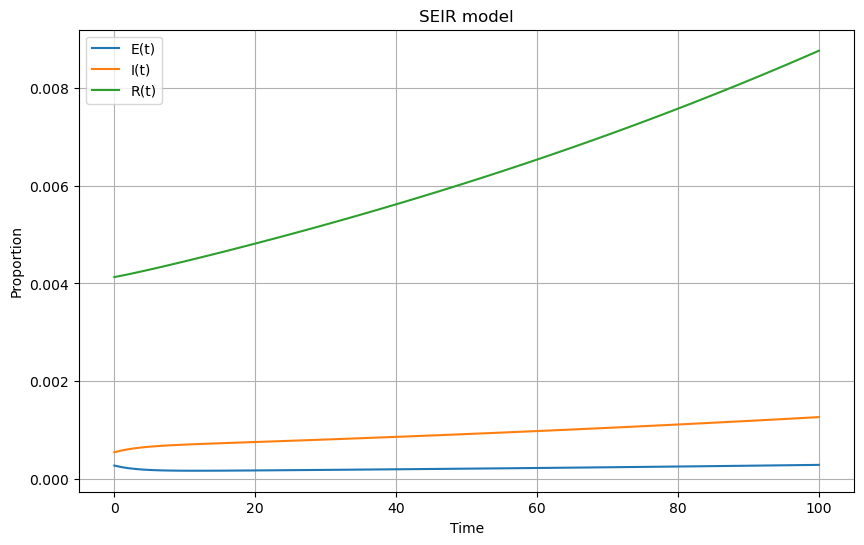

In [205]:
# plot result
plt.figure(figsize=(10,6))
# plt.plot(seir[:, 0], label="S(t)")
plt.plot(seir[:, 1], label="E(t)")
plt.plot(seir[:, 2], label="I(t)")
plt.plot(seir[:, 3], label="R(t)")
plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.title("SEIR model")
plt.show()
plt.close()

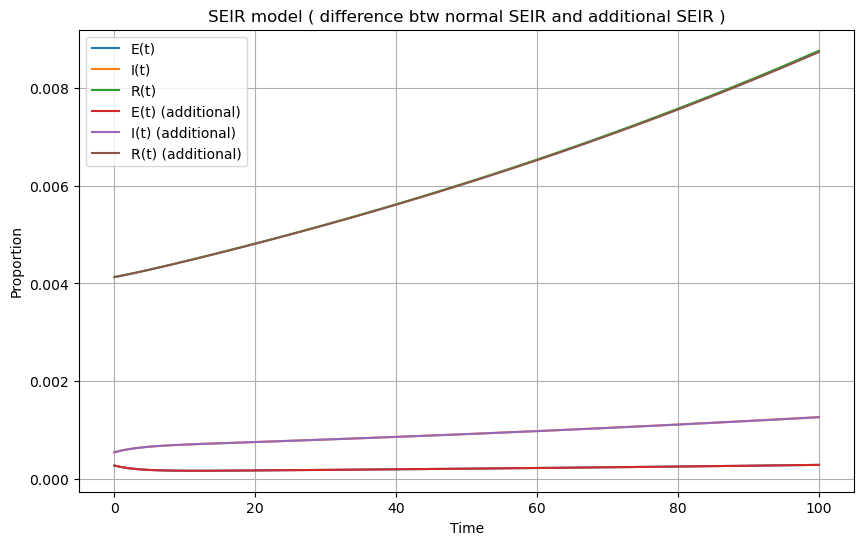

In [207]:
# plot result
seir_additional = sp.odeint(seir_additional_calculation, input_tuple, t_range)

plt.figure(figsize=(10,6))

# plt.plot(seir[:, 0], label="S(t)")
plt.plot(seir[:, 1], label="E(t)")
plt.plot(seir[:, 2], label="I(t)")
plt.plot(seir[:, 3], label="R(t)")

# plt.plot(seir_additional[:, 0], label="S(t) (additional)")
plt.plot(seir_additional[:, 1], label="E(t) (additional)")
plt.plot(seir_additional[:, 2], label="I(t) (additional)")
plt.plot(seir_additional[:, 3], label="R(t) (additional)")

plt.grid()
plt.legend()
plt.xlabel("Time")
plt.ylabel("Proportion")
plt.title("SEIR model ( difference btw normal SEIR and additional SEIR )")
plt.show()
plt.close()